# DDPLKO Moduł 10 - praca domowa - Binary classification

To dziesiąta praca domowa w Programie szkoleniowym Klasyfikacja obrazu od Deep Drive PL

Twoim zadaniem w tym module będzie:
- [ ] Wybór 2 klas ze zbioru Open Images (https://storage.googleapis.com/openimages/web/index.html)
- [ ] Wykonanie dwóch treningów (może być własny model, lepiej transfer learning):
  - [ ] Bez ważonego lossu
  - [ ] z ważonym lossem
- [ ] UWAGA - w obu treningach monitoruj balanced accuracy!
- [ ] Udostępnij po 1 przykładowym zdjęciu z wybranych klas oraz wykres z porównaniem wyników validation balanced accuracy na Discordzie `#klasyfikacja-wyniki`

>Aby pobrać zdjęcia dla 2 klas możesz skorzystać za załączonych notebooków

W przypadku problemów z wielkością tego zbioru:
- możesz pracować na zmniejszonej rozdzielczości np. 32x32px
- możesz zmniejszyć liczbę próbek, ale zachowując ich stosunek (nie wyrównuj liczebności, by móc skorzystać z balanced accuracy)

Extra - dodatkowo możesz:
- wytrenować modele różnej wielkości np. EffNetB0 i EffNetB2 czy R18, R50, R101
- narysować krzywe ROC i PR z porównaniem modeli

# 2 classes from OpenImages

In [1]:
import pandas as pd
import urllib.request
import pathlib
from sklearn.preprocessing import LabelEncoder

from torchvision.io import read_image
from torch.utils.data import Dataset
from pathlib import Path
from torchvision import transforms

In [10]:
train_classifications = 'https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-human-imagelabels.csv'
val_classifications = 'https://storage.googleapis.com/openimages/v5/validation-annotations-human-imagelabels.csv'
class_names = 'https://storage.googleapis.com/openimages/v6/oidv6-class-descriptions.csv'

urllib.request.urlretrieve(train_classifications, './openimages/train_classifications.csv')
urllib.request.urlretrieve(val_classifications, './openimages/val_classifications.csv')
urllib.request.urlretrieve(class_names, './openimages/class_names.csv');

In [11]:
df_train = pd.read_csv('./openimages/train_classifications.csv')
df_val = pd.read_csv('./openimages/val_classifications.csv')
df_classes = pd.read_csv('./openimages/class_names.csv')

In [12]:
df_train = pd.merge(df_train, df_classes, on='LabelName', how='left')
df_val = pd.merge(df_val, df_classes, on='LabelName', how='left')

In [13]:
selected_classes = ['Bus', 'Truck']

In [14]:
df_train = df_train[(df_train['DisplayName'] == selected_classes[0]) | (df_train['DisplayName'] == selected_classes[1])].reset_index(drop=True)
df_val = df_val[(df_val['DisplayName'] == selected_classes[0]) | (df_val['DisplayName'] == selected_classes[1])].reset_index(drop=True)

In [15]:
df_train = df_train[df_train['Confidence'] == 1].reset_index(drop=True)
df_val = df_val[df_val['Confidence'] == 1].reset_index(drop=True)

In [16]:
df_train.drop_duplicates(subset=['ImageID'], keep=False, inplace=True, ignore_index=True)
df_val.drop_duplicates(subset=['ImageID'], keep=False, inplace=True, ignore_index=True)

In [115]:
df_train.DisplayName.value_counts()

Bus      9328
Truck    1951
Name: DisplayName, dtype: int64

In [17]:
df_val.DisplayName.value_counts()

Truck    300
Bus       79
Name: DisplayName, dtype: int64

In [18]:
df_train['text_file'] = 'train/' + df_train['ImageID']
df_val['text_file'] = 'validation/' + df_val['ImageID']

In [19]:
for i, label in enumerate(selected_classes):
    with open('./openimages/download_train_' + str(i+1) + '.txt', 'a') as f:
        f.write(df_train[df_train['DisplayName'] == label].to_string(columns=['text_file'], header=False, index=False))
    
    with open('./openimages/download_val_' + str(i+1) + '.txt', 'a') as f:
        f.write(df_val[df_val['DisplayName'] == label].to_string(columns=['text_file'], header=False, index=False))

In [20]:
url = 'https://raw.githubusercontent.com/openimages/dataset/master/downloader.py'
urllib.request.urlretrieve(url, './openimages/downloader.py')

('./openimages/downloader.py', <http.client.HTTPMessage at 0x7fe2d93334d0>)

In [119]:
!python ./openimages/downloader.py ./openimages/download_train_1.txt --download_folder=./openimages/class_1/train/

Not found: 7194: 100%|██████████████████████| 9328/9328 [07:50<00:00, 19.81it/s]


In [120]:
!python ./openimages/downloader.py ./openimages/download_train_2.txt --download_folder=./openimages/class_2/train/

Not found: 239: 100%|███████████████████████| 1951/1951 [04:16<00:00,  7.60it/s]


In [21]:
!python ./openimages/downloader.py ./openimages/download_val_1.txt --download_folder=./openimages/class_1/validation/

In [22]:
!python ./openimages/downloader.py ./openimages/download_val_2.txt --download_folder=./openimages/class_2/validation/

### Dataset preprocessing

In [123]:
# delete not found files from df
with open('class_1_train_errors.txt', 'r') as f:
    for line in f.readlines():
        idx = df_train.index[(df_train["text_file"] == line[:-1])][0]
        df_train.drop(idx, inplace=True)

In [124]:
with open('class_2_train_errors.txt', 'r') as f:
    for line in f.readlines():
        idx = df_train.index[(df_train["text_file"] == line[:-1])][0]
        df_train.drop(idx, inplace=True)

In [125]:
df_train.DisplayName.value_counts()

Bus      2134
Truck    1712
Name: DisplayName, dtype: int64

In [23]:
df_val.DisplayName.value_counts()

Truck    300
Bus       79
Name: DisplayName, dtype: int64

In [24]:
# encode classes to 0 or 1

classes = list(df_val.DisplayName.unique())
le = LabelEncoder()
le.fit(classes)
classes = le.classes_.tolist()

In [25]:
y_val = le.transform(list(df_val.DisplayName))
y_train = le.transform(list(df_train.DisplayName))

df_val['CategoryID'] = y_val
df_train['CategoryID'] = y_train

In [26]:
df_train['file_loc'] = df_train.pop('text_file')
df_val['file_loc'] = df_val.pop('text_file')

In [130]:
# adjust file location
file_locs = {}
for index, row in df_train.iterrows():
    data = dict(row)
    file_locs[data['file_loc']] = f'class_{int(data["CategoryID"])+1}/{data["file_loc"]}'

df_train['file_loc'].replace(file_locs, inplace=True)    

In [27]:
file_locs = {}
for index, row in df_val.iterrows():
    data = dict(row)
    file_locs[data['file_loc']] = f'class_{int(data["CategoryID"])+1}/{data["file_loc"]}'
df_val['file_loc'].replace(file_locs, inplace=True)


# Dataset

In [101]:
input_size=(192, 192)

img_transforms = transforms.Compose([
    transforms.Resize(input_size),
])

class OpenImagesDataset(Dataset):
    def __init__(self, data:list, img_dir:Path, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        label = self.data[idx]['CategoryID']
        img_path = self.img_dir / f'{self.data[idx]["file_loc"]}.jpg'
        image = read_image(str(img_path))
        if image.shape[0] != 3:
            del self.data[idx]
        image = image / 255.0
        
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label).to(torch.long).float()
        return image, label

In [3]:
df_train = pd.read_pickle('df_train.pkl')
df_val = pd.read_pickle('df_val.pkl')

In [102]:
train_data = [dict(row) for _, row in df_train.iterrows()]
val_data = [dict(row) for _, row in df_val.iterrows()]

In [103]:
train_dataset = OpenImagesDataset(data=train_data,
                                 img_dir=Path('/home/jakub/Documents/deep_learning_course/10/10.09/openimages'),
                                 transform=img_transforms)
val_dataset = OpenImagesDataset(data=val_data,
                                 img_dir=Path('/home/jakub/Documents/deep_learning_course/10/10.09/openimages'),
                                 transform=img_transforms)

In [6]:
df_train.DisplayName.value_counts()

Bus      2097
Truck    1687
Name: DisplayName, dtype: int64

In [31]:
df_val.DisplayName.value_counts()

Truck    300
Bus       79
Name: DisplayName, dtype: int64

# Model

In [32]:
import timm
import torch
import torch.nn as nn
from collections import defaultdict
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pytorch_lightning as pl
from torchvision import transforms
import torchvision.models as models

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [33]:
class Model(pl.LightningModule):
    def __init__(self, model, class_weights=None, balanced_acc=False):
        super().__init__()
        
        self.model = model
        self.history = defaultdict(lambda: [])
        self.balanced_acc = balanced_acc
        self.class_weights=None if class_weights is None else torch.tensor(class_weights).to(torch.device('cuda'))

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x).squeeze()
        
        if self.class_weights is not None:
            loss = nn.BCEWithLogitsLoss(pos_weight=self.class_weights)(y_hat, y)
        else:    
            loss = nn.BCEWithLogitsLoss()(y_hat, y)
            
        y_hat = nn.Sigmoid()(y_hat)
        pred = (y_hat > 0.5) * 1
        
        if self.balanced_acc:
            acc = balanced_accuracy_score(y.detach().cpu().numpy(), pred.detach().cpu().numpy())
        else:
            acc = accuracy_score(y.detach().cpu().numpy(), pred.detach().cpu().numpy())
        
        self.log('train_loss', loss, on_epoch=True, on_step=True)
        self.log('train_acc', acc, on_epoch=True, on_step=True)
        
        return {'loss': loss, 'accuracy': acc}
    
    def training_epoch_end(self, outputs):
        mean_loss = torch.stack([x['loss'] for x in outputs]).mean()
        mean_acc = np.stack([x['accuracy'] for x in outputs]).mean()
        self.history['train_loss'].append(mean_loss.detach().cpu().item())
        self.history['train_acc'].append(mean_acc.item())
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x).squeeze()
        
        if self.class_weights is not None:
            loss = nn.BCEWithLogitsLoss(pos_weight=self.class_weights)(y_hat, y)
        else:    
            loss = nn.BCEWithLogitsLoss()(y_hat, y)
            
        y_hat = nn.Sigmoid()(y_hat)
        pred = (y_hat > 0.5) * 1
        
        if self.balanced_acc:
            acc = balanced_accuracy_score(y.detach().cpu().numpy(), pred.detach().cpu().numpy())
        else:
            acc = accuracy_score(y.detach().cpu().numpy(), pred.detach().cpu().numpy())

        
        self.log('val_loss', loss, on_epoch=True, on_step=True)
        self.log('val_acc', acc, on_epoch=True, on_step=True)
        
        return {'loss': loss, 'accuracy': acc}

    def validation_epoch_end(self, outputs):
        mean_loss = torch.stack([x['loss'] for x in outputs]).mean()
        mean_acc = np.stack([x['accuracy'] for x in outputs]).mean()
        self.history['val_loss'].append(mean_loss.detach().cpu().item())
        self.history['val_acc'].append(mean_acc.item())
        
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.model.parameters())
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        
        return [optim], [scheduler]

In [107]:
num_workers = 0
batch_size = 32
max_epochs = 40
num_classes = 1
gpus = 1

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=num_workers)

# Training - no class weights

In [170]:
df_train.DisplayName.value_counts()

Bus      2097
Truck    1687
Name: DisplayName, dtype: int64

In [35]:
from torch.utils import tensorboard
%load_ext tensorboard
%tensorboard --logdir logs/EffNetV2_b0 --port 6006

In [10]:
tb_logger = pl.loggers.TensorBoardLogger('logs/EffNetV2_b0')

In [179]:
effnetv2_b0 = timm.create_model('tf_efficientnetv2_b0', pretrained=True, num_classes=1)
effnetv2_b0 = Model(effnetv2_b0)
trainer = pl.Trainer(max_epochs=max_epochs, 
                     gpus=gpus, 
                     num_sanity_val_steps=0,
                     logger=tb_logger,
                     callbacks=[EarlyStopping(
                         monitor='val_acc',
                         mode='max',
                         verbose=True,
                         patience=5
                     )])
trainer.fit(effnetv2_b0, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 5.9 M 
---------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.440    Total estimated model params size (MB)
/home/jakub/anaconda3/envs/deep_learning_env/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/jakub/anaconda3/envs/deep_learning_env/lib/python3.7/site-packages/pytorch_lightning/trainer/data_

Epoch 1:  93%|█████████▎| 220/236 [03:38<00:15,  1.01it/s, loss=0.15, v_num=0]

Epoch 0:  50%|█████     | 118/236 [01:19<01:19,  1.49it/s, loss=0.489, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 236/236 [02:25<00:00,  1.63it/s, loss=0.489, v_num=0]
                                                             

Metric val_acc improved. New best score: 0.929


Epoch 1:  50%|█████     | 118/236 [01:18<01:18,  1.51it/s, loss=0.135, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 236/236 [02:31<00:00,  1.57it/s, loss=0.135, v_num=0]
                                                             

Metric val_acc improved by 0.054 >= min_delta = 0.0. New best score: 0.984


Epoch 2:  50%|█████     | 118/236 [01:26<01:25,  1.37it/s, loss=0.0888, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 236/236 [02:37<00:00,  1.50it/s, loss=0.0888, v_num=0]
                                                             

Metric val_acc improved by 0.014 >= min_delta = 0.0. New best score: 0.998


Epoch 3:  50%|█████     | 118/236 [01:24<01:23,  1.41it/s, loss=0.0165, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 118/236 [01:24<01:24,  1.40it/s, loss=0.0233, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating:  86%|████████▋ | 102/118 [01:00<00:09,  1.70it/s]


Epoch 5:  50%|█████     | 118/236 [01:25<01:24,  1.39it/s, loss=0.144, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 118/236 [01:25<01:25,  1.39it/s, loss=0.182, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  87%|████████▋ | 206/236 [02:20<00:20,  1.48it/s, loss=0.182, v_num=0]


Epoch 7:  50%|█████     | 118/236 [01:26<01:25,  1.37it/s, loss=0.0815, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 236/236 [02:39<00:00,  1.49it/s, loss=0.0815, v_num=0]
                                                             

Monitored metric val_acc did not improve in the last 5 records. Best score: 0.998. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 236/236 [02:39<00:00,  1.49it/s, loss=0.0815, v_num=0]


In [184]:
resnet18 = timm.create_model('resnet18', pretrained=True, num_classes=1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jakub/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [186]:
tb_logger = pl.loggers.TensorBoardLogger('logs/EffNetV2_b0', name='resnet18')
resnet18 = Model(resnet18)
trainer = pl.Trainer(max_epochs=max_epochs, 
                     gpus=gpus, 
                     num_sanity_val_steps=0,
                     logger=tb_logger,
                     callbacks=[EarlyStopping(
                         monitor='val_acc',
                         mode='max',
                         verbose=True,
                         patience=5
                     )])
trainer.fit(resnet18, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)
/home/jakub/anaconda3/envs/deep_learning_env/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/jakub/anaconda3/envs/deep_learning_env/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarn

Epoch 0:   0%|          | 1/236 [00:01<02:23,  1.63it/s, loss=0.67, v_num=0]

/home/jakub/anaconda3/envs/deep_learning_env/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0:  50%|█████     | 118/236 [01:22<01:21,  1.45it/s, loss=0.409, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 236/236 [02:33<00:00,  1.55it/s, loss=0.409, v_num=0]
                                                             

Metric val_acc improved. New best score: 0.709


Epoch 1:  50%|█████     | 118/236 [01:19<01:18,  1.50it/s, loss=0.347, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 236/236 [02:30<00:00,  1.57it/s, loss=0.347, v_num=0]
                                                             

Metric val_acc improved by 0.174 >= min_delta = 0.0. New best score: 0.883


Epoch 0:   0%|          | 0/236 [46:51<184:19:47, 2811.81s/it]=0.416, v_num=0] 


Exception ignored in: <function tqdm.__del__ at 0x7f36b317c680>
Traceback (most recent call last):
  File "/home/jakub/anaconda3/envs/deep_learning_env/lib/python3.7/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/home/jakub/anaconda3/envs/deep_learning_env/lib/python3.7/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


Epoch 2:  50%|█████     | 118/236 [01:21<01:20,  1.46it/s, loss=0.331, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 118/236 [01:19<01:19,  1.49it/s, loss=0.265, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating:  88%|████████▊ | 104/118 [01:00<00:08,  1.62it/s]


Epoch 3: 100%|██████████| 236/236 [02:29<00:00,  1.58it/s, loss=0.265, v_num=0]
                                                             

Metric val_acc improved by 0.012 >= min_delta = 0.0. New best score: 0.895


Epoch 4:  50%|█████     | 118/236 [01:23<01:22,  1.43it/s, loss=0.249, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 236/236 [02:34<00:00,  1.54it/s, loss=0.249, v_num=0]
                                                             

Metric val_acc improved by 0.039 >= min_delta = 0.0. New best score: 0.934


Epoch 5:  50%|█████     | 118/236 [01:21<01:21,  1.46it/s, loss=0.198, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 236/236 [02:33<00:00,  1.55it/s, loss=0.198, v_num=0]
                                                             

Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.941


Epoch 6:  50%|█████     | 118/236 [01:24<01:23,  1.41it/s, loss=0.155, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 118/236 [01:20<01:20,  1.47it/s, loss=0.147, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating:  88%|████████▊ | 104/118 [00:59<00:08,  1.71it/s]


Epoch 8:  50%|█████     | 118/236 [01:17<01:16,  1.54it/s, loss=0.104, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 236/236 [02:25<00:00,  1.63it/s, loss=0.104, v_num=0]
                                                             

Metric val_acc improved by 0.028 >= min_delta = 0.0. New best score: 0.969


Epoch 9:  50%|█████     | 118/236 [01:18<01:17,  1.53it/s, loss=0.0824, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10:  50%|█████     | 118/236 [01:32<01:31,  1.29it/s, loss=0.0501, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10:  93%|█████████▎| 220/236 [02:34<00:11,  1.43it/s, loss=0.0501, v_num=0]


Epoch 10: 100%|██████████| 236/236 [02:45<00:00,  1.44it/s, loss=0.0501, v_num=0]
                                                             

Metric val_acc improved by 0.018 >= min_delta = 0.0. New best score: 0.987


Epoch 11:  50%|█████     | 118/236 [01:23<01:22,  1.43it/s, loss=0.11, v_num=0]   
Validating: 0it [00:00, ?it/s]
Epoch 12:  50%|█████     | 118/236 [01:20<01:19,  1.48it/s, loss=0.035, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 12:  94%|█████████▍| 222/236 [02:23<00:08,  1.56it/s, loss=0.035, v_num=0]


Epoch 12: 100%|██████████| 236/236 [02:32<00:00,  1.56it/s, loss=0.035, v_num=0]
                                                             

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.988


Epoch 13:  50%|█████     | 118/236 [01:20<01:20,  1.47it/s, loss=0.0226, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████| 236/236 [02:33<00:00,  1.54it/s, loss=0.0226, v_num=0]
                                                             

Metric val_acc improved by 0.000 >= min_delta = 0.0. New best score: 0.988


Epoch 14:  50%|█████     | 118/236 [01:21<01:20,  1.46it/s, loss=0.0217, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 14: 100%|██████████| 236/236 [02:33<00:00,  1.54it/s, loss=0.0217, v_num=0]
                                                             

Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.992


Epoch 15:  50%|█████     | 118/236 [01:21<01:21,  1.45it/s, loss=0.0213, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 15: 100%|██████████| 236/236 [02:32<00:00,  1.55it/s, loss=0.0213, v_num=0]
                                                             

Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.996


Epoch 16:  50%|█████     | 118/236 [01:22<01:21,  1.45it/s, loss=0.0373, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 17:  50%|█████     | 118/236 [01:22<01:21,  1.44it/s, loss=0.0176, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating:  85%|████████▍ | 100/118 [00:59<00:10,  1.76it/s]


Epoch 18:  50%|█████     | 118/236 [01:23<01:22,  1.43it/s, loss=0.0441, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 18: 100%|██████████| 236/236 [02:34<00:00,  1.54it/s, loss=0.0441, v_num=0]
                                                             

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.997


Epoch 19:  50%|█████     | 118/236 [01:21<01:20,  1.47it/s, loss=0.0226, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 20:  50%|█████     | 118/236 [01:22<01:21,  1.45it/s, loss=0.014, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 20:  93%|█████████▎| 220/236 [02:22<00:10,  1.55it/s, loss=0.014, v_num=0]


Epoch 20: 100%|██████████| 236/236 [02:32<00:00,  1.55it/s, loss=0.014, v_num=0]
                                                             

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.999


Epoch 21:  50%|█████     | 118/236 [01:21<01:20,  1.46it/s, loss=0.00307, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 21: 100%|██████████| 236/236 [02:32<00:00,  1.55it/s, loss=0.00307, v_num=0]
                                                             

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 1.000


Epoch 22:  50%|█████     | 118/236 [01:19<01:19,  1.49it/s, loss=0.00161, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 23:  50%|█████     | 118/236 [01:22<01:21,  1.45it/s, loss=0.00477, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating:  83%|████████▎ | 98/118 [00:56<00:11,  1.67it/s]


Epoch 24:  50%|█████     | 118/236 [01:22<01:21,  1.44it/s, loss=0.000579, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 25:  50%|█████     | 118/236 [01:22<01:21,  1.44it/s, loss=0.000853, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating:  66%|██████▌   | 78/118 [00:48<00:24,  1.62it/s]


Epoch 26:  50%|█████     | 118/236 [01:19<01:19,  1.49it/s, loss=0.000485, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 26: 100%|██████████| 236/236 [02:31<00:00,  1.57it/s, loss=0.000485, v_num=0]
                                                             

Monitored metric val_acc did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


Epoch 26: 100%|██████████| 236/236 [02:31<00:00,  1.57it/s, loss=0.000485, v_num=0]


In [95]:
%matplotlib inline
def plot_results(models, labels):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for model in models:
        for metric, values in model.history.items():
            epochs = list(range(0, len(values)))
            row = 0 if metric.split('_')[0] == 'train' else 1
            col = 0 if metric.split('_')[1] == 'loss' else 1
            
            axs[row, col].plot(epochs, values)
            axs[row, col].set_title(' '.join(metric.split('_')))
            axs[row, col].legend(labels)
            axs[row, col].grid()

In [15]:
resnet18 = timm.create_model('resnet18', pretrained=True, num_classes=1)
tb_logger = pl.loggers.TensorBoardLogger('logs/EffNetV2_b0', name='resnet18_ba')
resnet18 = Model(resnet18, balanced_acc=True)
trainer = pl.Trainer(max_epochs=max_epochs, 
                     gpus=gpus, 
                     num_sanity_val_steps=0,
                     logger=tb_logger,
                     callbacks=[EarlyStopping(
                         monitor='val_acc',
                         mode='max',
                         verbose=True,
                         patience=5
                     )])
trainer.fit(resnet18, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)
/home/jakub/anaconda3/envs/deep_learning_env/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/jakub/anaconda3/envs/deep_learning_env/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarn

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc improved. New best score: 0.775


Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.126 >= min_delta = 0.0. New best score: 0.901


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.018 >= min_delta = 0.0. New best score: 0.919


Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.033 >= min_delta = 0.0. New best score: 0.952


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.972


Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.023 >= min_delta = 0.0. New best score: 0.995


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_acc did not improve in the last 5 records. Best score: 0.995. Signaling Trainer to stop.


# Training - weighted loss

In [32]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', 
                                                 classes=np.unique(list(df_train.CategoryID)), 
                                                 y=list(df_train.CategoryID))

In [29]:
df_train.CategoryID.value_counts()

0    2097
1    1687
Name: CategoryID, dtype: int64

In [50]:
resnet18_weighted = timm.create_model('resnet18', pretrained=True, num_classes=1)
tb_logger = pl.loggers.TensorBoardLogger('logs/EffNetV2_b0', name='resnet18__weighted')
resnet18_weighted = Model(resnet18_weighted, balanced_acc=True, class_weights=class_weight[1])

trainer = pl.Trainer(max_epochs=max_epochs, 
                     gpus=gpus, 
                     num_sanity_val_steps=0,
                     logger=tb_logger,
                     callbacks=[EarlyStopping(
                         monitor='val_acc',
                         mode='max',
                         verbose=True,
                         patience=5
                     )])
trainer.fit(resnet18_weighted, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)


tensor(1.1215, device='cuda:0', dtype=torch.float64)


/home/jakub/anaconda3/envs/deep_learning_env/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/jakub/anaconda3/envs/deep_learning_env/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc improved. New best score: 0.870


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.033 >= min_delta = 0.0. New best score: 0.902


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.038 >= min_delta = 0.0. New best score: 0.940


Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.019 >= min_delta = 0.0. New best score: 0.959


Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.963


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.968


Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.014 >= min_delta = 0.0. New best score: 0.982


Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.983


Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.012 >= min_delta = 0.0. New best score: 0.995


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.997


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.999


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 1.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_acc did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


# Balanced accuracy - without vs with weighted loss

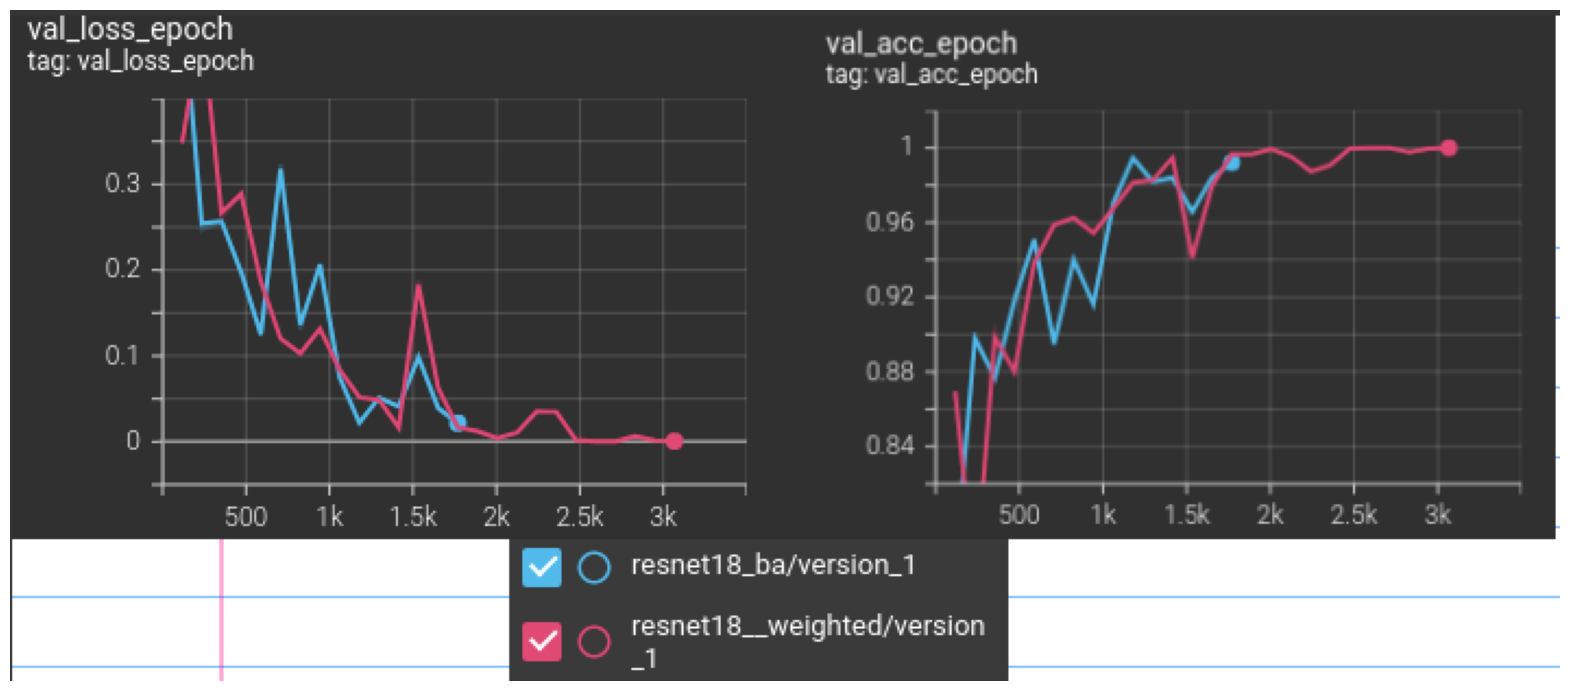

In [61]:
from PIL import Image
results = Image.open('results.png')
plt.figure(figsize=(20, 13))
plt.imshow(results)
plt.axis('off')
plt.show()

# Summary / extra

In [72]:
def rename_state_dict_keys(state_dict):
    old_dict = dict(state_dict)
    renamed_dict = dict()
    for layer_name in state_dict.keys():
        renamed_layer = '.'.join(layer_name.split('.')[1:])
        renamed_dict[renamed_layer] = old_dict.pop(layer_name)
    return renamed_dict

In [141]:
# model  initialization
resnet18 = timm.create_model('resnet18', pretrained=True, num_classes=1)
state_dict = dict(torch.load('./logs/EffNetV2_b0/resnet18/version_0/checkpoints/epoch=26-step=3185.ckpt')['state_dict'])
renamed_state_dict = rename_state_dict_keys(state_dict)
resnet18.load_state_dict(renamed_state_dict)

<All keys matched successfully>

In [172]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score

def plot_roc(y_true, y_pred, label='', title=''):
    plt.figure(figsize=(7, 7))
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc_score = auc(fpr, tpr)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])

    plt.plot(fpr, tpr, label=label + ' AUC = {0:0.4f}'.format(roc_auc_score))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.axis('tight')
    plt.tight_layout()
    plt.title(title)
    plt.legend()
    plt.grid()

In [173]:
def plot_pr(y_true, y_pred, label='', title=''):
    plt.figure(figsize=(7, 7))
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    avg_precision = average_precision_score(y_true, y_pred)

    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.05])

    plt.plot(recall, precision, label=label+' AP = {0:0.4f}'.format(avg_precision))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.axis('tight')
    plt.grid()

In [174]:
%matplotlib inline

In [156]:
def evaluate_model(model, val_dataloader):
    predictions = []
    labels = []
    for idx, (data, target) in enumerate(val_dataloader):
        pred = (nn.Sigmoid()(model(data).squeeze()) > 0.5)*1
        predictions.extend(pred.numpy())
        labels.extend(target.numpy())
    return predictions, labels

In [157]:
resnet18_results = evaluate_model(resnet18, val_dataloader)

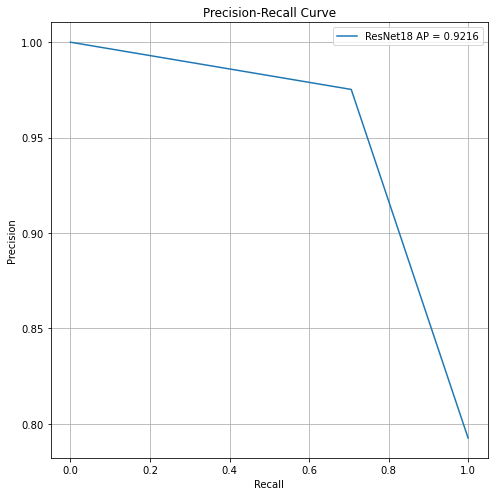

In [175]:
plot_pr(y_true=resnet18_results[1],
        y_pred=resnet18_results[0],
       label='ResNet18', title='Precision-Recall Curve')

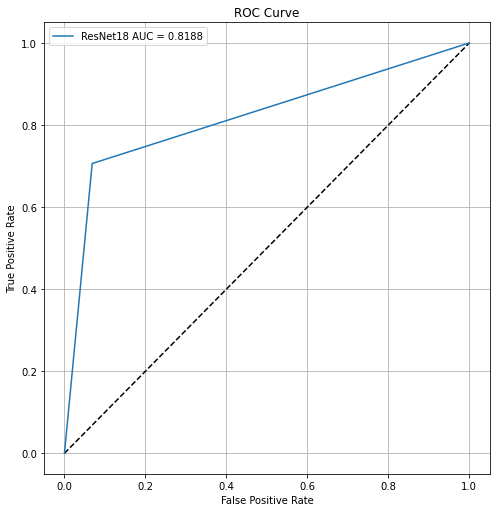

In [177]:
plot_roc(y_true=resnet18_results[1],
        y_pred=resnet18_results[0],
       label='ResNet18', title='ROC Curve')

    niebieski - resnet18
    żółty - balanced accuracy
    fioletowy - balanced_accuracy+weighted_loss

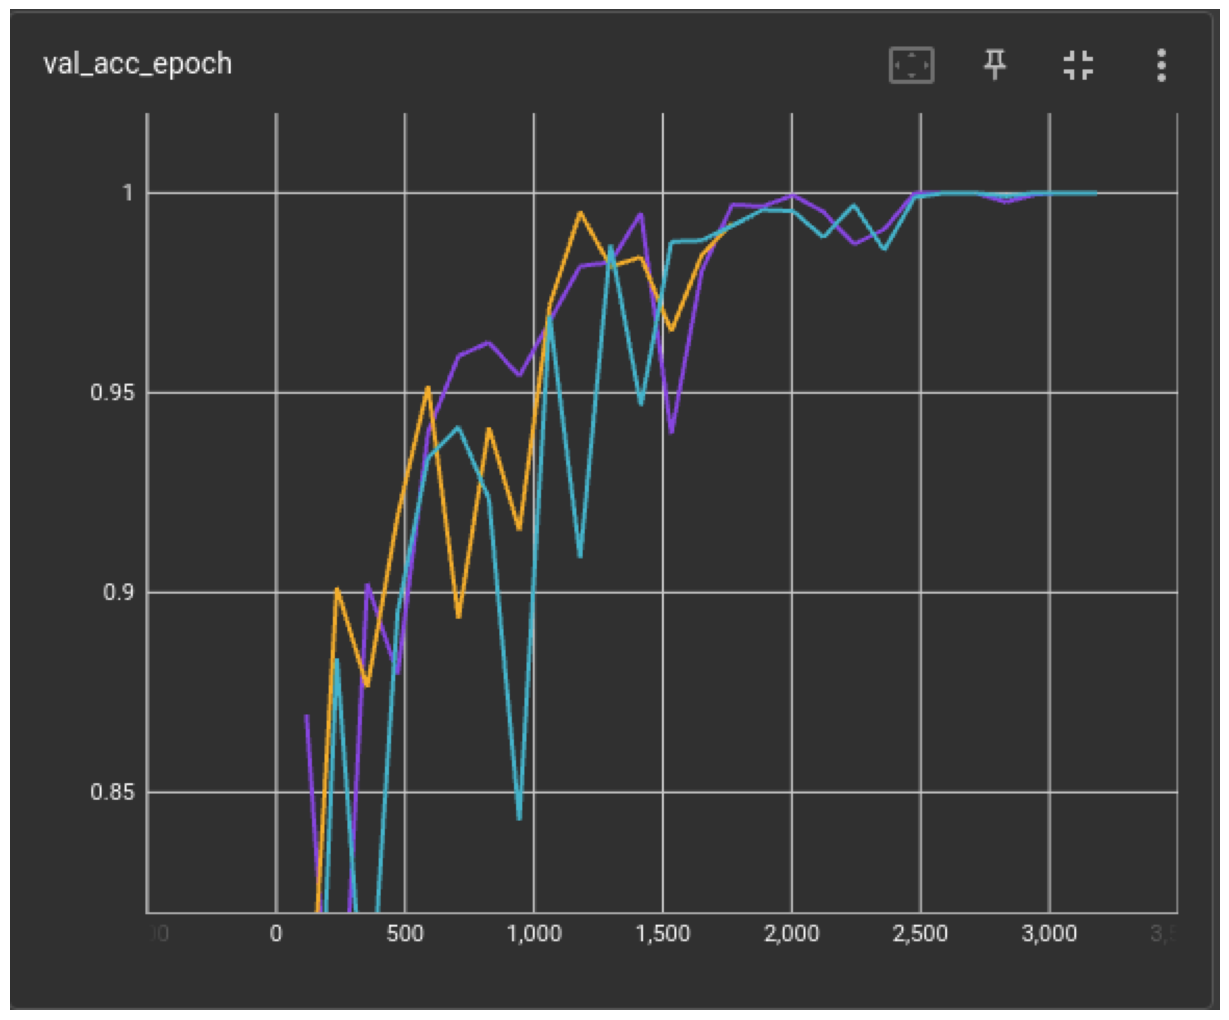

In [62]:
from PIL import Image
results = Image.open('summary.png')
plt.figure(figsize=(20, 13))
plt.imshow(results)
plt.axis('off')
plt.show()

# Wyślij rozwiązanie
Możesz skorzystać z jednego z poniższych sposobów:
**mailem na specjalny adres** ze strony pracy domowej w panelu programu prześlij jedno z poniższych:
- notebooka (jeżeli plik ma mniej niż np. 10MB)
- notebooka w zipie
- link do Colaba (udostępniony)
- link do pliku przez GDrive/Dropboxa/WeTransfer/...
- pdfa (poprzez download as pdf)
- jako plik w repozytorium na np. GitHubie, by budować swoje portfolio (wtedy uważaj na wielkość pliku, najlepiej kilka MB, Max 25MB)

Najlepiej, by w notebooku było widać wyniki uruchomienia komórek, chyba, że przez nie plik będzie mieć 100+MB wtedy najlepiej Colab lub jakieś przemyślenie co poszło nie tak (zbyt dużo dużych zdjęć wyświetlonych w komórkach).

## Co otrzymasz?
Informację zwrotną z ewentualnymi sugestiami, komentarzami.